In [1]:
import pandas as pd
import numpy as np
import shapefile as shp  # Requires the pyshp package
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random
from tqdm import tqdm
import pickle
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression as LR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.svm import SVR 
from sklearn.ensemble import AdaBoostRegressor as ADA
from sklearn.ensemble import BaggingRegressor as BAG
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.linear_model import RANSACRegressor as RAN
from sklearn.linear_model import PassiveAggressiveRegressor as PAR
from sklearn.linear_model import SGDRegressor as SGD
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_regression
from sklearn import preprocessing

# Class ensemble_search

In [2]:
class ensemble_search:
    def __init__(self, X_train, y_train, X_test, y_test, size_pop=20, epochs=5, train_test_size=0.2,
                 early_stop=False, alpha_early_stop=1E-3):
        
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.size_pop = size_pop
        self.epochs = epochs
        self.fitness_array_ = np.array([])
        self.best_of_all_ = None
        self.early_stop = early_stop
        self.alpha_early_stop = alpha_early_stop

    def gen_population(self):
        population = [[]]*self.size_pop
        # default
        lista_LR = ['LR', LR(), 1]
        lista_RFR = ['RFR', RFR(), 1]
        lista_SVR = ['SVR', SVR(), 1]
        lista_ADA = ['ADA', ADA(), 1]
        lista_BAG = ['BAG', BAG(), 1]
        lista_GBR = ['GBR', GBR(), 1]
        lista_RAN = ['RAN', RAN(), 1]
        lista_PAR = ['PAR', PAR(), 1]
        lista_SGD = ['SGD', SGD(), 1]
        lista_default = [lista_LR,lista_RFR,lista_SVR,lista_ADA,lista_BAG,lista_GBR,lista_RAN,lista_PAR,lista_SGD]
        max_len = len(lista_default)
        population[0] = [max_len, lista_default, 'voting_regressor', np.inf]    
        
        for i in range(1, self.size_pop):
            qt_regressor = np.random.randint(2,max_len)
            
            lista_LR = ['LR', LR().set_params(**{}), np.random.randint(1,qt_regressor)]
            
            lista_RFR = ['RFR',RFR().set_params(**{'n_estimators':np.random.randint(1,50),'max_depth':np.random.randint(1,20),
                                       'min_samples_split':np.random.randint(2,5),
                                       'min_samples_leaf':np.random.randint(2,10),
                                       'min_weight_fraction_leaf':np.random.rand(1)[0]/2}),
                        np.random.randint(1,qt_regressor)]
            
            lista_SVR = ['SVR',SVR().set_params(**{'kernel':random.choice(['linear','rbf','poly','sigmoid']),
                                      'epsilon':np.random.rand(1)[0]/4,
                                      'C':random.choice([1,10,100]),'gamma':'auto'}),
                         np.random.randint(1,qt_regressor)]
            
            lista_ADA = ['ADA',ADA().set_params(**{'n_estimators':np.random.randint(1,50)}),
                         np.random.randint(1,qt_regressor)]
            
            lista_BAG = ['BAG',BAG().set_params(**{'n_estimators':np.random.randint(1,50),
                                                   'max_samples':np.random.randint(1,20)}), 
                        np.random.randint(1,qt_regressor)]
            
            lista_GBR = ['GBR',GBR().set_params(**{'n_estimators':np.random.randint(1,50),
                                                   'max_depth':np.random.randint(1,20),
                                                    'min_samples_split':np.random.randint(2,5),
                                                    'min_samples_leaf':np.random.randint(2,10),
                                                    'min_weight_fraction_leaf':np.random.rand(1)[0]/2}),
                        np.random.randint(1,qt_regressor)]
        
            lista_RAN = ['RAN',RAN().set_params(**{}),
                        np.random.randint(1,qt_regressor)]
            
            lista_PAR = ['PAR',PAR().set_params(**{'C': np.random.randint(1,10), 'early_stopping':True,
                                       'n_iter_no_change':np.random.randint(1,10)}),
                        np.random.randint(1,qt_regressor)]
            
            lista_SGD = ['SGD',SGD().set_params(**{}),
                        np.random.randint(1,qt_regressor)]
            
            # estas listas são sobre a estrutura dos regressores para a votação, cada um precisa do nome, objeto
            # e parâmetros.
            lista_regressors = [lista_LR,lista_RFR,lista_SVR,lista_ADA,lista_BAG,lista_GBR,lista_RAN,
                                lista_PAR,lista_SGD]
            
            random.shuffle(lista_regressors)
            
            lista_regressors = lista_regressors[0:qt_regressor]

            population[i] = [qt_regressor, lista_regressors, 'voting_regressor_object', np.inf]
                    
        return population

    def set_fitness(self, population):
        # i de individuo
        for i in range(len(population)):
            # vai precisar fazer isso só se for np.inf para não ficar rodando de novo ensembles que já
            # tiveram o fitness definido
            
            lista_tuplas_VR = []
            nomes = []                
            for reg in population[i][1]:
                #adicionar X se o nome já estiver dentro, se não da bug no voting regressor.
                while reg[0] in nomes: 
                    reg[0] = reg[0]+'X'
                nomes.append(reg[0])

                #aqui vai pegando cada regressor do indivíduo (lista de regressores),
                #que é formado pelo nome do regressor e o objeto.
                lista_tuplas_VR.append((reg[0],reg[1])) 


            weigths = np.array(list(map(lambda x: x[2], population[i][1])))
            Voting_regressor = VotingRegressor(lista_tuplas_VR, weigths)
            Voting_regressor.fit(self.X_train, self.y_train)
            mae_vr = mae(Voting_regressor.predict(self.X_test), self.y_test)
            population[i][-1] = mae_vr
            population[i][-2] = Voting_regressor #Objeto voting Regressor

        return population
    
    def next_population(self, population):
        # sempre faz o sort antes desse método, então aqui já vai estar elitizando.
        sum_fit_pop = np.array(population)[:,-1].sum()
        # i de individuos
        # quarda 10% sempre
        for i in range(int(len(population)*0.1), len(population)):
            # aqui mistura as listas de regressores, pq esse é o jeito de misturar os regressores.
            # o novo objeto é formado no método set_fitness
            # está misturando os regressores de todos os caras da população
            # como os melhores tem mae menor, population[i][-1], então a probabilidade dos melhores de cruzar  
            # vai ser menor. Assim na esperança vai dar que para cruzar o mae tem que ser mais de 25% do valor total
            # ou seja, esse individuo é bem ruim.
            if population[i][-1] > random.random()*sum_fit_pop/2: 
                
                # pai 1 vai ser o individuo i
                qt_regs_pai1 = population[i][0]
                
                # pai 2 vai ser o individuo oposto -i
                qt_regs_pai2 = population[-i][0]
                
                # se o pai1 tiver menos regressores que o pai 2, então limita pelo pai 1 e virse-versa
                if qt_regs_pai1<=qt_regs_pai2:    
                    population[i][1][:int(qt_regs_pai1/2)] = population[-i][1][:int(qt_regs_pai1/2)]
                    # mutação no peso 0.33 de chance de não mutar.
                    for w in range(int(qt_regs_pai1/2)):
                        population[i][1][w][2] += np.random.randint(2)
                else:
                    population[i][1][:int(qt_regs_pai2/2)] = population[-i][1][:int(qt_regs_pai2/2)]
                
                population[i][-1] = np.inf
        
        return population
    
    def early_stop(self):
        array = self.fitness_array_
        to_break=False
        if len(array) > int(self.epochs/2):
            array_diff1 = array[1:] - array[:-1]
            array_diff2 = array_diff1[1:] - array_diff1[:-1]
            # quero minimizar, então a concavidade tem que ser para cima 
            # e a derivada próximo de zero falta a ordem de grandeza da derivada.
            if array_diff2[-int(self.epochs/3):].mean() > 0 and abs(
                array_diff1[-int(self.epochs/3):].mean()) < self.alpha_early_stop:
                
                to_break = True  
                
        return to_break

    def search_best(self):
        population = self.gen_population()
        self.best_of_all_ = None
        for e in tqdm(range(self.epochs)):
            population = self.set_fitness(population)
            # faz sorte pelo ultimo elemento da lista na população que é o mae
            population.sort(key = lambda x: x[-1])
            print(np.array(population)[0,-1])
            
            # na primeira iteração 0 não tem nada no fitness_array_
            if e > 0:
                if population[0][-1] < min(self.fitness_array_):
                    self.best_of_all_ = population[0][-2]  
                    
            # vai salvando o fitness do melhor de cada época
            self.fitness_array_ = np.append(self.fitness_array_, population[0][-1])
            
            population = self.next_population(population)
            
            if self.early_stop:
                if self.early_stop():
                    break
            
        return self

In [ ]:
n_samples = 1000
X, y, coef = make_regression(n_samples=n_samples, n_features=1,n_informative=1, noise=10,coef=True, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

Ensearch = ensemble_search(X_train, y_train, X_test, y_test, size_pop=20, epochs=5).search_best()
print(mae(Ensearch.best_of_all_.predict(X_test), y_test))

# Load data

In [3]:
df_all = pd.read_csv('df_todas_colunas.csv').drop(['ID','VisibilidadeMedia'], axis=1) #só nan em visibilidade media
df_all.iloc[:,3:-1] = preprocessing.minmax_scale(df_all.iloc[:,3:-1].values)

scaler_fator_capacidade_NE = preprocessing.MinMaxScaler()

df_all.iloc[:,-1] = scaler_fator_capacidade_NE.fit_transform(df_all.iloc[:,-1].values.reshape(-1, 1))

df_all.fillna(method='pad', inplace=True)

df_all.head()

,UF,LON,LAT,VelocidadeVentoMedia,VelocidadeVentoMaximaMedia,EvaporacaoPiche,EvapoBHPotencial,EvapoBHReal,InsolacaoTotal,NebulosidadeMedia,...,global_horizontal_means_NE,par_means_NE,tilted_latitude_means_NE,pvgis_sarah_Em,pvgis_sarah_Hm,pvgis_sarah_SDm,pvgis_nsrdb_Em,pvgis_nsrdb_Hm,pvgis_nsrdb_SDm,fator_capacidade_NE
0,Pernambuco,-40.749,-9.5005,0.541407,0.47441,0.975221,0.585622,0.0,0.875611,0.491887,...,0.798959,0.745698,0.786325,0.704545,0.701754,0.285553,0.822222,0.842105,0.212682,0.548675
1,Pernambuco,-40.649,-9.5005,0.541407,0.47441,0.975221,0.585622,0.0,0.875611,0.491887,...,0.769681,0.717017,0.755424,0.704545,0.701754,0.275395,0.777778,0.789474,0.195509,0.544431
2,Pernambuco,-40.549,-9.5005,0.541407,0.47441,0.975221,0.585622,0.0,0.875611,0.491887,...,0.741054,0.676864,0.724523,0.659091,0.666667,0.312641,0.688889,0.719298,0.191546,0.540194
3,Pernambuco,-40.749,-9.4005,0.541407,0.47441,0.975221,0.585622,0.0,0.875611,0.491887,...,0.800260,0.751434,0.785667,0.727273,0.736842,0.260722,0.755556,0.771930,0.157199,0.529998
4,Pernambuco,-40.649,-9.4005,0.541407,0.47441,0.975221,0.585622,0.0,0.875611,0.491887,...,0.785296,0.738050,0.769888,0.681818,0.701754,0.287810,0.755556,0.789474,0.206077,0.525178


In [4]:
X = df_all.drop(['UF','fator_capacidade_NE', 'LAT', 'LON'], axis=1)
Y = df_all.fator_capacidade_NE

# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=1)

### Dump X_train, X_test, Y_train, Y_test

In [ ]:
# pickle.dump(X_train, open('X_train_best_ensemble.pkl', 'wb'))
# pickle.dump(X_test, open('X_test_best_ensemble.pkl', 'wb'))
# pickle.dump(y_train, open('y_train_best_ensemble.pkl', 'wb'))
# pickle.dump(y_test, open('y_test_best_ensemble.pkl', 'wb'))

### Load X_train, X_test, Y_train, Y_test

In [23]:
X_train = pickle.load(open('X_train_best_ensemble.pkl', 'rb'))
X_test = pickle.load(open('X_test_best_ensemble.pkl', 'rb'))
y_train = pickle.load(open('y_train_best_ensemble.pkl', 'rb'))
y_test = pickle.load(open('y_test_best_ensemble.pkl', 'rb'))

# Test Default

In [6]:
runtimes=3
maes = []
mses = []
for i in tqdm(range(runtimes)):

    r1 = LR()
    r2 = RFR()
    r3 = SVR()
    r4 = ADA()
    r5 = BAG()
    r6 = GBR()
    r7 = RAN()
    r8 = PAR()
    r9 = SGD()

    er = VotingRegressor([('lr', r1), ('rf', r2), ('svr', r3), ('ada', r4), ('bag', r5), ('gbr', r6),
                          ('ransac', r7), ('par', r8), ('sgd', r9)])

    er.fit(X_train, y_train)
    y_pred = er.predict(X_test)
    maes.append(mae(y_pred, y_test))
    mses.append(mse(y_pred, y_test))

100%|██████████| 3/3 [00:37<00:00, 12.35s/it]


In [68]:
#plt.hist(maes, bins=int(1+3.3*np.log10(runtimes)))
print(min(maes))

0.05232515335141941


# Otimizando

In [18]:
Ensearch = ensemble_search(X_train, y_train, X_test, y_test, size_pop=15, epochs=7).search_best()
ensearch_best = Ensearch.best_of_all_
print("final: ", Ensearch.fitness_array_.min())

 14%|█▍        | 1/7 [01:24<08:24, 84.13s/it]

0.0544000131255463


 29%|██▊       | 2/7 [03:04<07:25, 89.14s/it]

0.04643031517997612


 43%|████▎     | 3/7 [04:49<06:15, 93.85s/it]

0.045838788228866285


 57%|█████▋    | 4/7 [06:43<04:59, 99.69s/it]

0.04631299359176376


 71%|███████▏  | 5/7 [08:33<03:25, 102.78s/it]

0.046440859686420706


 86%|████████▌ | 6/7 [10:18<01:43, 103.54s/it]

0.04530186686510587


100%|██████████| 7/7 [12:05<00:00, 103.63s/it]

0.04582106007937716
final:  0.04530186686510587


In [71]:
y_pred_ensearch = ensearch_best.predict(X_test)

mae_default = min(maes)
mse_default = min(mses)

mae_ensearch = mae(y_pred_ensearch, y_test)
mse_ensearch = mse(y_pred_ensearch, y_test)

print('Default Best')
print('MAE: ', mae_default)
print('MSE: ', mse_default)

print('Ensearch Best')
print('MAE: ', mae_ensearch)
print('MSE: ', mse_ensearch)

print('Improve')
print('MAE: ', 1-mae_ensearch/mae_default)
print('MSE: ', 1-mse_ensearch/mse_default)

Default Best
MAE:  0.05232515335141941
MSE:  0.004346929348243896
Ensearch Best
MAE:  0.04530186686510587
MSE:  0.003269740512892151
Improve
MAE:  0.13422390640968884
MSE:  0.24780454179383316


In [ ]:

print(min(maes)-)

## Dump best searched

In [20]:
pickle.dump(ensearch_best, open('Best_ensemble.pkl', 'wb'))

# Load best searched

In [21]:
best_er = pickle.load(open('Best_ensemble.pkl', 'rb'))
y_pred_ensearch = best_er.predict(X_test)

In [25]:
y_pred_ensearch = best_er.predict(X_test)
print('Ensearch Best')
print('MAE: ', mae(y_pred_ensearch, y_test))
print('MSE: ', mse(y_pred_ensearch, y_test))

Ensearch Best
MAE:  0.04530186686510587
MSE:  0.003269740512892151


### TO plot

In [26]:
to_plot_results = df_all.loc[:,['LAT', 'LON']].copy()
Y_true = scaler_fator_capacidade_NE.inverse_transform(Y.values.reshape(-1, 1))
Y_hat = scaler_fator_capacidade_NE.inverse_transform(best_er.predict(X).reshape(-1, 1))
to_plot_results['Cap_IA'] = Y_hat
to_plot_results['Cap_IA_erro'] = abs(Y_true - Y_hat)

# Visualizar Resultado

## Colocar mapa com erro entre modelo e valor real.

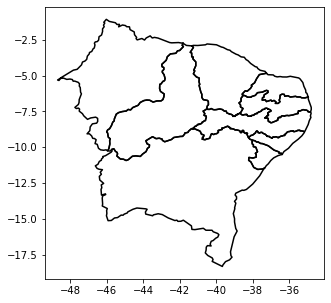

In [27]:
sf = shp.Reader("SHP_NE/Nordeste.shp")

NE_map = []
for shape in sf.shapeRecords():
    x0 = [i[0] for i in shape.shape.points[:]]
    x1 = [i[1] for i in shape.shape.points[:]]
    NE_map.append([x0, x1])
    
plt.figure(figsize=(5,5))
for i in range(0,len(NE_map)):
        axis = plt.plot(NE_map[i][0], NE_map[i][1],'k-')

In [58]:
usinas_locais = pd.read_excel('GEN_ONS/usinas_local.xlsx')

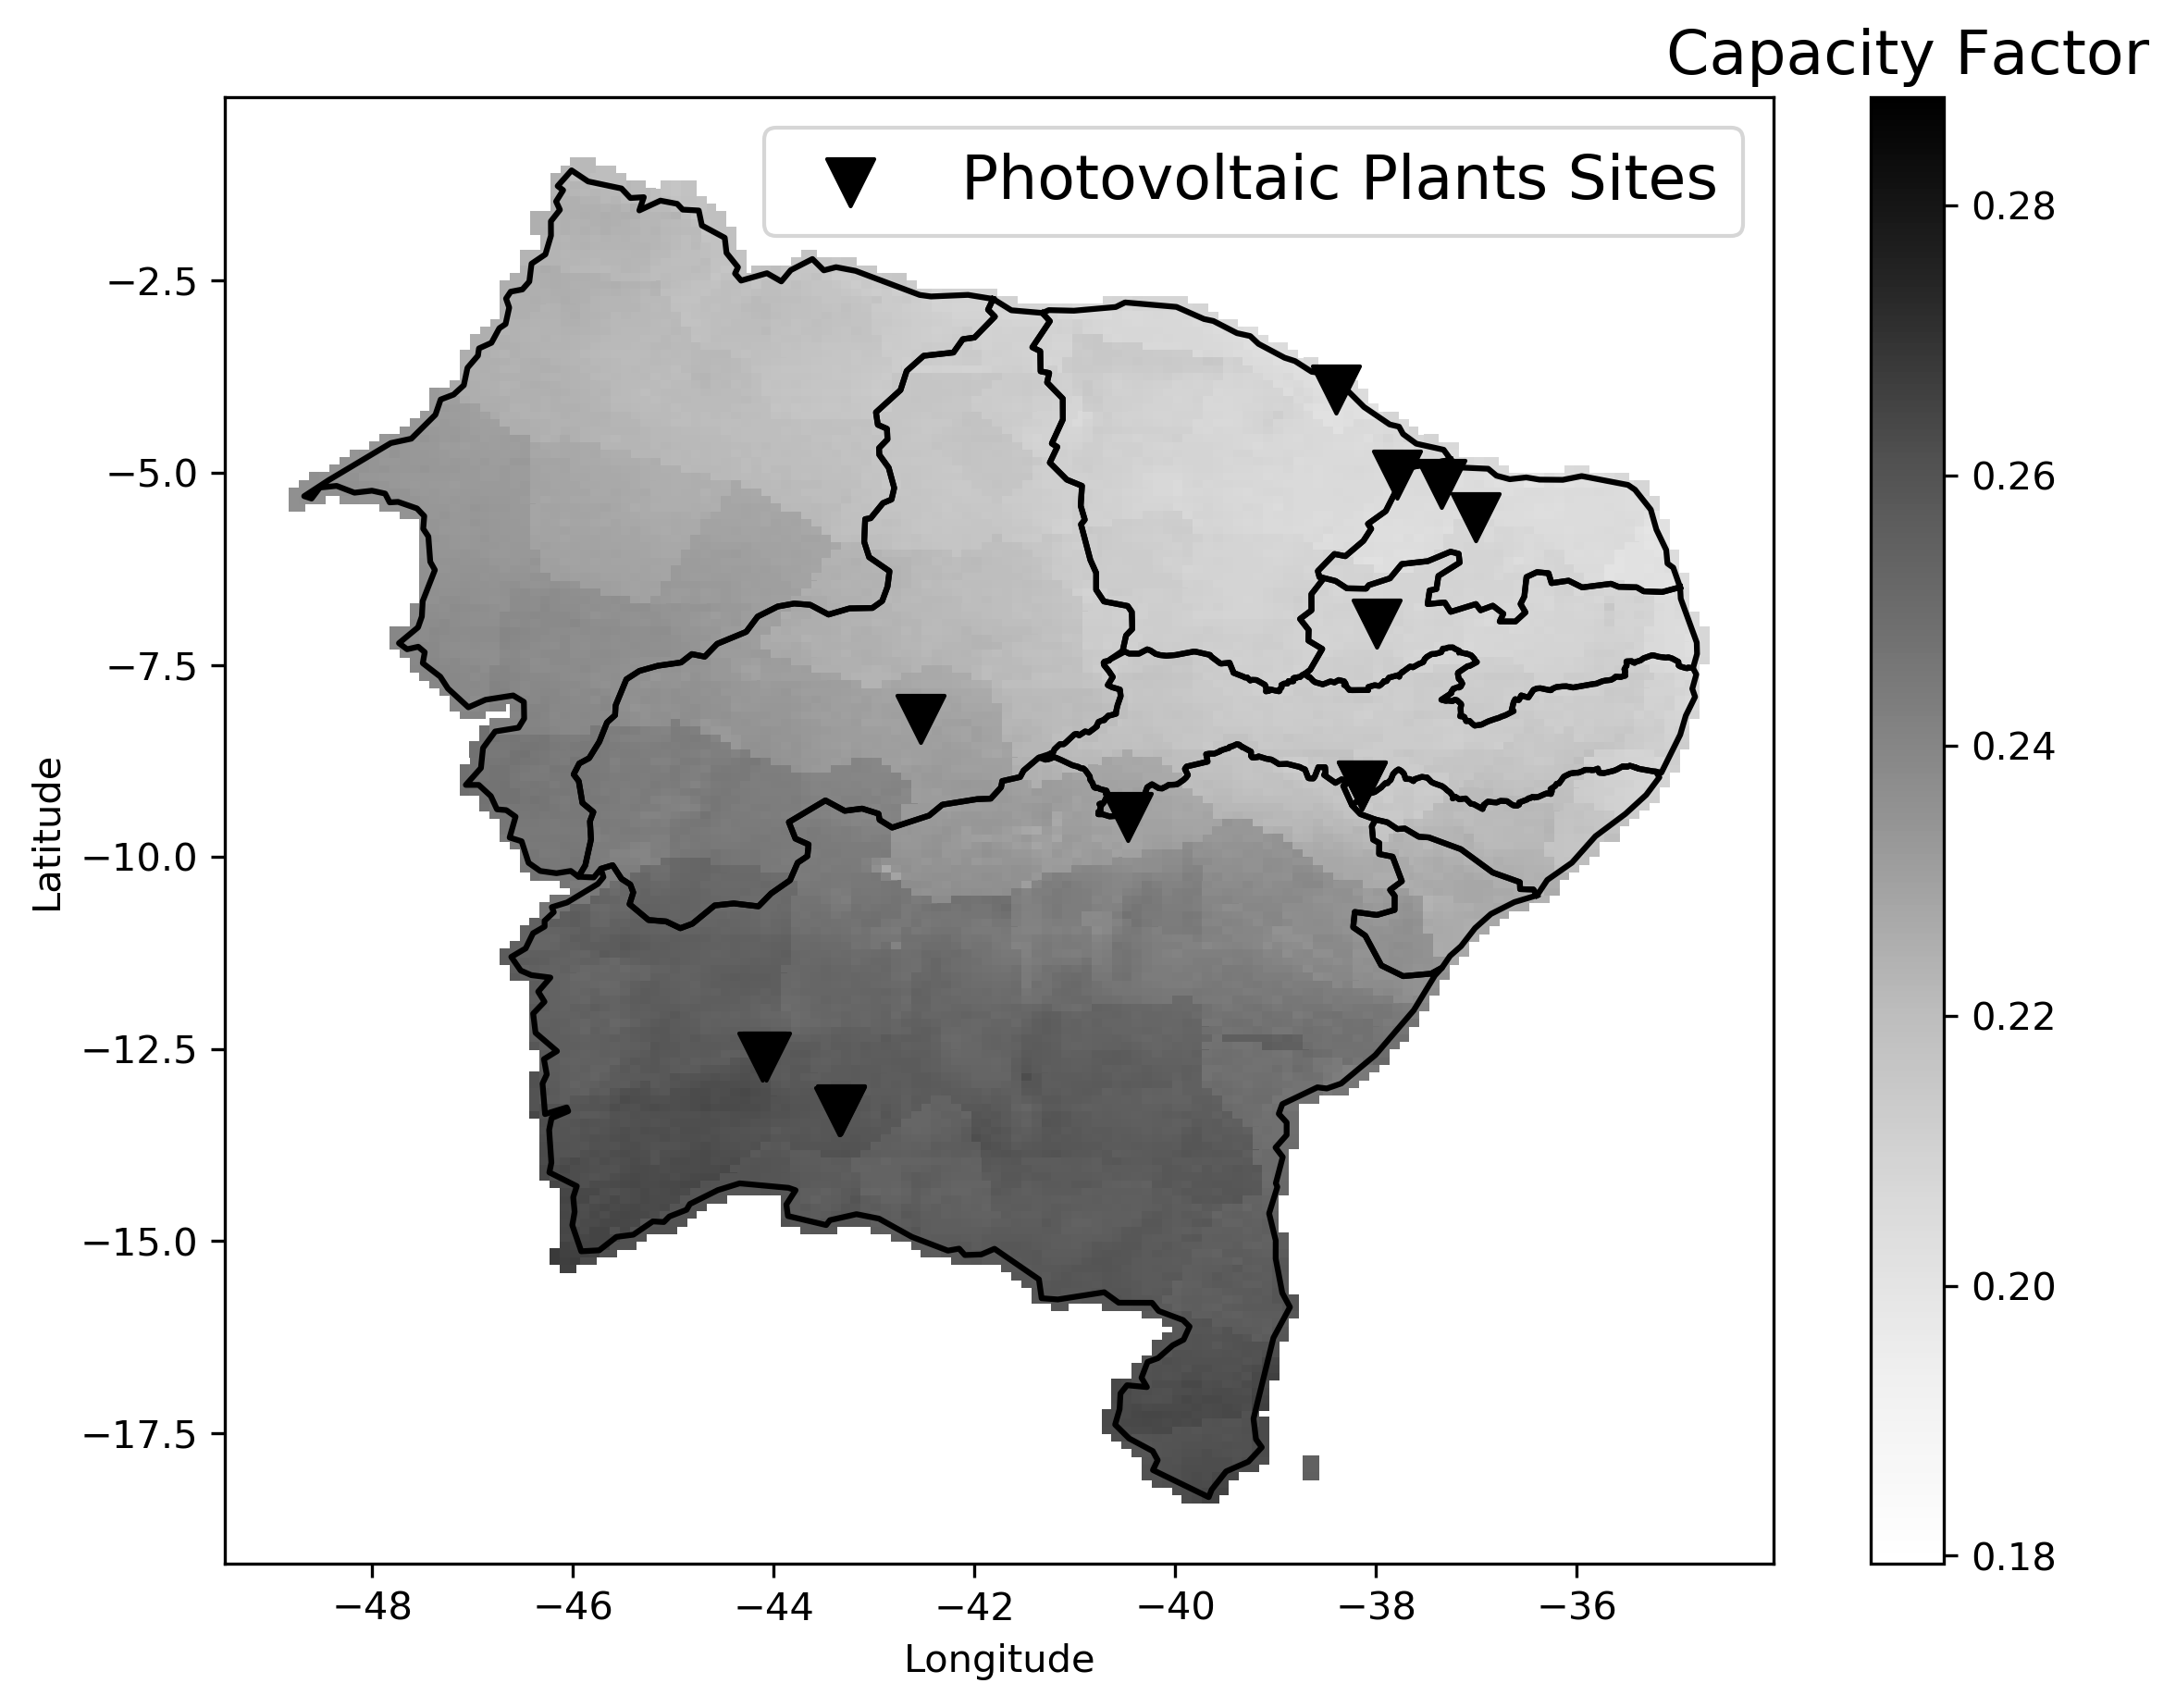

In [67]:
mpl.rcParams["scatter.marker"] = 's'

fig, ax1 = plt.subplots(1, 1, figsize=(9,7), dpi=300)

for i in range(0,len(NE_map)):
        ax1.plot(NE_map[i][0], NE_map[i][1],'k-')
                        
min_colormap = to_plot_results.Cap_IA.min() - 0.02
max_colormap = to_plot_results.Cap_IA.max() + 0.02

plot_s = sns.scatterplot(data=to_plot_results, x='LON', y='LAT', hue='Cap_IA',
                         hue_norm=(min_colormap,max_colormap), legend=False, 
                         palette = 'Greys', size='Cap_IA', sizes=(15,20), linewidth=0, ax=ax1)

norm = plt.Normalize(min_colormap,max_colormap)
sm = plt.cm.ScalarMappable(cmap="Greys", norm=norm)
sm.set_array([])

clb = plot_s.figure.colorbar(sm)
clb.ax.set_title('Capacity Factor',fontdict={'fontsize':16})

ax1.scatter(usinas_locais.Longitude, usinas_locais.Latitude, s=150, c='k',
             marker="v", alpha=1, label="Photovoltaic Plants Sites")
ax1.legend(fontsize=16)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

plt.savefig('figuras/capacidade_IA', dpi=300)

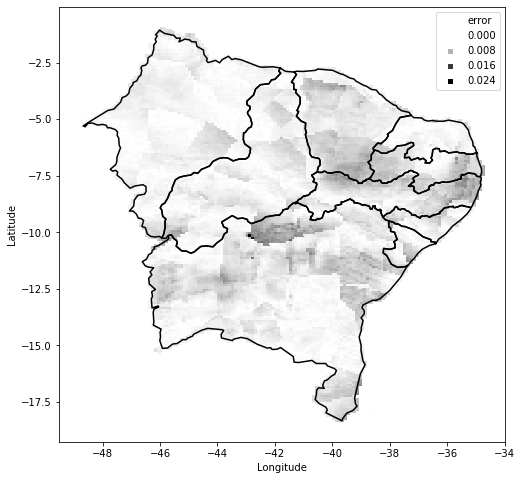

In [30]:
mpl.rcParams["scatter.marker"] = 's'

fig, ax1 = plt.subplots(figsize=(8, 8), sharex=True)

for i in range(0,len(NE_map)):
        ax1.plot(NE_map[i][0],NE_map[i][1],'k-')
                        
sns.scatterplot(data=to_plot_results, x='LON', y='LAT', hue='Cap_IA_erro',
                palette = 'Greys', size='Cap_IA_erro', sizes=(15,20), linewidth=0, ax=ax1)

ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

leg = ax1.legend_
for t in leg.texts[1:]:
    # truncate label text to 4 characters
    t.set_text(t.get_text()[:5])
leg.texts[0].set_text('error')

plt.savefig('figuras/erro_capacidade_IA', dpi=300)

In [32]:
df_with_ensemble = pd.read_csv('df_todas_colunas.csv').drop(['ID','VisibilidadeMedia'], axis=1) #só nan em visibilidade media
df_with_ensemble['Cap_IA'] = to_plot_results['Cap_IA']
df_with_ensemble['Cap_IA_erro'] = to_plot_results['Cap_IA_erro']
df_with_ensemble.to_csv('df_todas_colunas_plus_IA.csv')